<a href="https://colab.research.google.com/github/julioagarcia/1DMT/blob/main/1DMT_NN_Inversion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import torch
import torch.nn as nn
import torch.utils.data as data_utils
from torch.utils.data import DataLoader, TensorDataset
import time
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler

In [4]:
#Create knots to plot predicted resistivity model

dz = 72.45875
n_layer = 52
z_factor = 1.05
knots = dz*z_factor**np.arange(n_layer-2)[::1]
knots = np.cumsum(knots)
knots = np.insert(knots, 0, 0)

In [5]:
#Build neural network class and define architecture

class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3, hidden_size4, hidden_size5, hidden_size6, output_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1) #layer 1
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size1, hidden_size2) #layer 2
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size2, hidden_size3) #layer 3
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(hidden_size3, hidden_size4) #layer 4
        self.relu4 = nn.ReLU()
        self.fc5 = nn.Linear(hidden_size4, hidden_size5) #layer 5
        self.relu5 = nn.ReLU()
        self.fc6 = nn.Linear(hidden_size5, hidden_size6) #layer 6
        self.relu6 = nn.ReLU()
        self.fc7 = nn.Linear(hidden_size6, output_size) #ouput layer

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        x = self.relu3(x)
        x = self.fc4(x)
        x = self.relu4(x)
        x = self.fc5(x)
        x = self.relu5(x)
        x = self.fc6(x)
        x = self.relu6(x)
        x = self.fc7(x)
        return x

#Build model architecture
input_size = 56  #Input dimension
hidden_size1 = 128  #Number of neurons in the hidden layer 1
hidden_size2 = 256  #Number of neurons in the hidden layer 2
hidden_size3 = 512  #Number of neurons in the hidden layer 3
hidden_size4 = 1024 #Number of neurons in the hidden layer 4
hidden_size5 = 512  #Number of neurons in the hidden layer 7
hidden_size6 = 128  #Number of neurons in the hidden layer 8
output_size = 51  #Output dimension
model = NeuralNetwork(input_size, hidden_size1, hidden_size2, hidden_size3, hidden_size4, hidden_size5, hidden_size6, output_size)
criterion = nn.MSELoss()  # Mean Squared Error
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  #Adam

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
#Load data tensors

input_data = torch.load("/content/drive/My Drive/ColabNotebooks/SimPEG/1DMTInversion/input_data.pt")
target_data = torch.load("/content/drive/My Drive/ColabNotebooks/SimPEG/1DMTInversion/target_data.pt")
input_tensor = torch.tensor(input_data, dtype=torch.float32)
target_tensor = torch.tensor(target_data, dtype=torch.float32)
# Check for NaN values in the input and target tensors
if torch.isnan(input_tensor).any() or torch.isnan(target_tensor).any():
    print("Input or target data contains NaN values.")

In [8]:
#Prepare data for training

#Printed a few entries from the datasets to verify their condition
print("Original Input Data Samples:")
print(input_tensor[:3])  # Print the  first original entry of the input dataset
print(target_tensor[:3])  # Print the converted first entry of the input dataset
num_dataset = len(input_data)
print(num_dataset)

#Create a StandardScaler instance for target tensor
target_scaler = StandardScaler().fit(target_tensor)
scaled_target_tensor = torch.from_numpy(target_scaler.transform(target_tensor)).float()

#Convert appartent resistivites to log10 and phases to radians
for n in range(num_dataset):
    inner_array = input_tensor[n]
    even_indices = np.arange(len(inner_array)) % 2 == 0
    odd_indices = ~even_indices
    inner_array[even_indices] = np.log10(inner_array[even_indices])  # Convert even elements (app. res.) to log10
    inner_array[odd_indices] = np.deg2rad(inner_array[odd_indices])  # Convert odd elements (phases) from degrees to radians

#Split input and output tensors into training and testing sets
split_ratio = 0.8
split = int(len(input_tensor) * split_ratio)
train_input = input_tensor[:split]
train_target = scaled_target_tensor[:split]
test_input = input_tensor[split:]
test_target = scaled_target_tensor[split:]

#Even and odd columns for the different train and test sizes
even_train_columns = np.arange(train_input.shape[1]) % 2 == 0
odd_train_columns = ~even_train_columns
even_test_columns = np.arange(test_input.shape[1]) % 2 == 0
odd_test_columns = ~even_test_columns

#Create a StandardScaler instance for even columns
even_scaler = StandardScaler().fit(train_input[:, even_train_columns])
scaled_even_train_input = np.copy(train_input)
scaled_even_train_input[:, even_train_columns] = even_scaler.transform(train_input[:, even_train_columns])
scaled_even_test_input = np.copy(test_input)
scaled_even_test_input[:, even_test_columns] = even_scaler.transform(test_input[:, even_test_columns])

#Create a StandardScaler instance for odd columns
odd_scaler = StandardScaler().fit(train_input[:, odd_train_columns])
scaled_odd_train_input = np.copy(train_input)
scaled_odd_train_input[:, odd_train_columns] = odd_scaler.transform(train_input[:, odd_train_columns])
scaled_odd_test_input = np.copy(test_input)
scaled_odd_test_input[:, odd_test_columns] = odd_scaler.transform(test_input[:, odd_test_columns])

#Concatenate scaled even and odd columns back together
scaled_train_input = np.concatenate((scaled_even_train_input[:, even_train_columns], scaled_odd_train_input[:, odd_test_columns]), axis=1)
scaled_test_input = np.concatenate((scaled_even_test_input[:, even_test_columns], scaled_odd_test_input[:, odd_test_columns]), axis=1)

#Convert to PyTorch tensors with dtype torch.float32
scaled_train_input = torch.from_numpy(scaled_train_input).float()
scaled_test_input = torch.from_numpy(scaled_test_input).float()

#Apply Standard Scaler to training and test input sets
#scaler = StandardScaler().fit(train_input)
#scaled_train_input = torch.from_numpy(scaler.transform(train_input)).float()
#scaled_test_input = torch.from_numpy(scaler.transform(test_input)).float()

#Printed a few entries from the datasets to verify their condition
print("Converted Input Data Samples:")
print(scaled_train_input[:3])  # Print the converted first entry of the input dataset
print(test_target[:3])  # Print the converted first entry of the input dataset

#Create data loaders for training and testing
train_dataset = TensorDataset(scaled_train_input, train_target)
test_dataset = TensorDataset(scaled_test_input, test_target)
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

Original Input Data Samples:
tensor([[ 1.2792, 34.8758,  1.2101, 34.9597,  1.0217, 38.8281,  1.0586, 41.4527,
          1.0382, 43.8510,  1.0801, 42.1447,  1.0592, 43.5383,  1.1408, 46.5572,
          1.0549, 42.7087,  1.1111, 47.6829,  1.1926, 46.0561,  1.0902, 44.7556,
          1.1025, 49.1450,  1.1481, 43.5880,  1.1270, 42.9882,  1.0744, 47.6679,
          1.0499, 46.1972,  1.1583, 43.3139,  1.1083, 43.7344,  1.0729, 43.3888,
          1.1302, 44.8818,  1.1226, 49.6309,  1.1352, 45.1759,  1.1925, 46.2938,
          1.1308, 43.0084,  1.1461, 43.1331,  1.0808, 43.4036,  1.0810, 44.9606],
        [ 0.8347, 69.7604,  1.2142, 77.9549,  1.6804, 82.3469,  2.7252, 80.6057,
          3.9046, 79.7523,  6.5204, 79.0812,  9.8181, 75.4303, 13.1301, 70.7798,
         16.6479, 68.1704, 21.3612, 66.6713, 27.0572, 67.3216, 34.4325, 70.5353,
         49.3922, 65.2582, 72.8828, 60.3358, 85.0377, 48.9205, 84.6564, 45.2706,
         80.0630, 35.0127, 61.7162, 37.1103, 47.0068, 35.1284, 43.3875, 44.1231

In [9]:
scaled_train_input.shape

torch.Size([80528, 56])

In [10]:
train_target.shape

torch.Size([80528, 51])

In [11]:
input_tensor.shape

torch.Size([100660, 56])

In [12]:
target_tensor.shape

torch.Size([100660, 51])

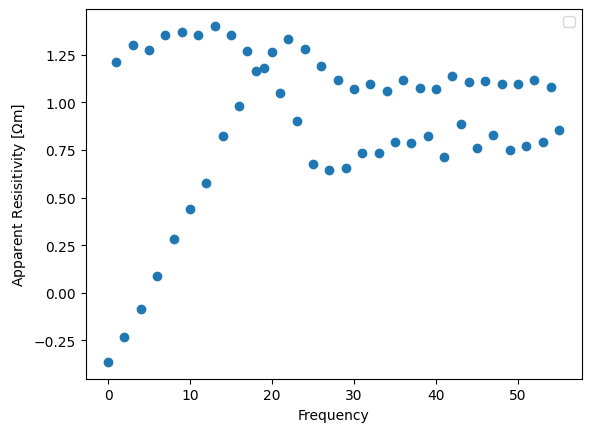

In [13]:
plt.plot(input_tensor[6].numpy(),'o')
plt.legend()
plt.xlabel('Frequency')
plt.ylabel('Apparent Resisitivity [$\Omega$m]')
plt.show()

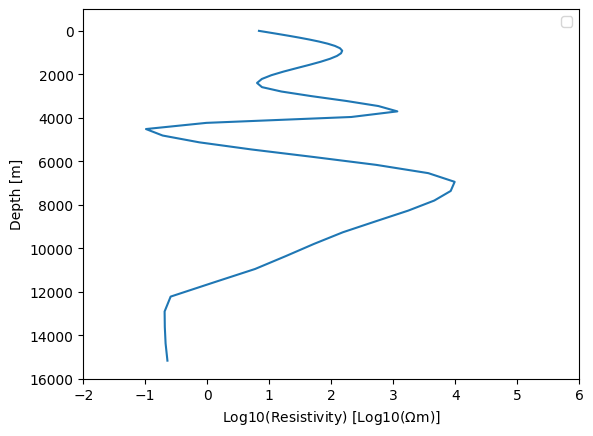

In [14]:
plt.plot(target_tensor[6].numpy(),knots, '-')
plt.legend()
plt.xlabel('Log10(Resistivity) [Log10($\Omega$m)]')
#plt.xscale("log")
plt.ylabel('Depth [m]')
plt.ylim(16000,-1000)
plt.xlim(-2, 6)
plt.show()

In [16]:
#Train model
start_time = time.time()
num_epochs = 100
for epoch in range(num_epochs):
    for inputs, targets in train_loader:
        #Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        #Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    #if (epoch + 1) % 10 == 0:
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
print("--- %s seconds ---" % (time.time() - start_time))

#Evaluate model on test dataset
model.eval()
total_loss = 0.0
with torch.no_grad():
    for inputs, targets in test_loader:
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        total_loss += loss.item()
mean_loss = total_loss / len(test_loader)
print(f"Mean squared error on test set: {mean_loss:.4f}")

Epoch [1/100], Loss: 0.7382
Epoch [2/100], Loss: 0.6289
Epoch [3/100], Loss: 0.6081
Epoch [4/100], Loss: 0.7242
Epoch [5/100], Loss: 0.6445
Epoch [6/100], Loss: 0.7069
Epoch [7/100], Loss: 0.7429
Epoch [8/100], Loss: 0.5473
Epoch [9/100], Loss: 0.7151
Epoch [10/100], Loss: 0.6977
Epoch [11/100], Loss: 0.5186
Epoch [12/100], Loss: 0.5497
Epoch [13/100], Loss: 0.7505
Epoch [14/100], Loss: 0.5690
Epoch [15/100], Loss: 0.4184
Epoch [16/100], Loss: 0.6235
Epoch [17/100], Loss: 0.5890
Epoch [18/100], Loss: 0.8880
Epoch [19/100], Loss: 0.7990
Epoch [20/100], Loss: 0.5866
Epoch [21/100], Loss: 0.5950
Epoch [22/100], Loss: 0.4067
Epoch [23/100], Loss: 0.5387
Epoch [24/100], Loss: 0.5580
Epoch [25/100], Loss: 0.7661
Epoch [26/100], Loss: 0.5725
Epoch [27/100], Loss: 0.6876
Epoch [28/100], Loss: 0.5667
Epoch [29/100], Loss: 0.3973
Epoch [30/100], Loss: 0.5810
Epoch [31/100], Loss: 0.5232
Epoch [32/100], Loss: 0.5922
Epoch [33/100], Loss: 0.7028
Epoch [34/100], Loss: 0.7317
Epoch [35/100], Loss: 0

In [17]:
#Display resistivity-depth model and forward modelled phase and apparent resistivities (pulled from SimPEG tutorial)

#fig = plt.figure(figsize=(16, 5))
#gs = gridspec.GridSpec(1, 5, figure=fig)
#ax0 = fig.add_subplot(gs[0, 0])
#plot_1d_layer_model(layer_thicknesses[::-1], rho_layers[::-1], ax=ax0, color="k", **{'label':'True'})
#ax0.set_xlabel("Resistivity [$\Omega$m]")
#ax0.set_xlim(0.01, 15000)
#ax0.set_ylim(16000,-100)
# ax0.set_yscale('log')
#ax = fig.add_subplot(gs[0, 2:])
#ax.loglog(frequencies, dobs.reshape((len(frequencies), 2))[:,0], color='C0', label='AppRes.')
#ax.loglog(frequencies[0], dobs.reshape((len(frequencies), 2))[0,0], color='C1', label='Phase')
#ax_1 = ax.twinx()
#ax_1.plot(frequencies, dobs.reshape((len(frequencies), 2))[:,1], color='C1')
#ax.set_xlabel("Frequency [Hz]")
#ax_1.set_ylim(0, 90)
#ax.grid(True, which='both', alpha=0.5)
#ax.set_ylabel("Apparent resistivity [$\Omega$m]")
#ax_1.set_ylabel("Phase [$\degree$]")
#ax.legend(bbox_to_anchor=(-0.1, 1))
#ax.set_xlim(100000,0.0001)
#ax.set_xlim(frequencies.max(), frequencies.min())
#plt.show()

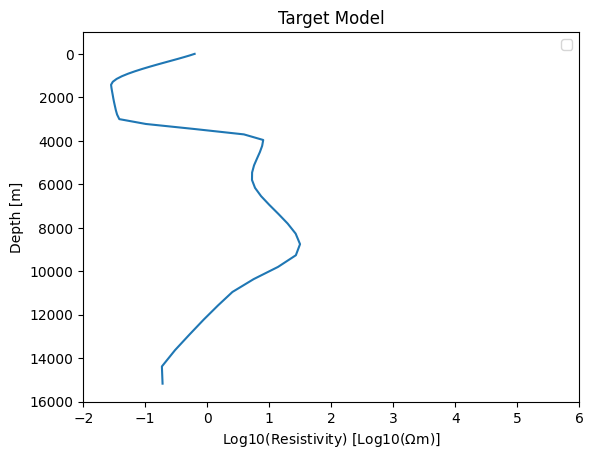

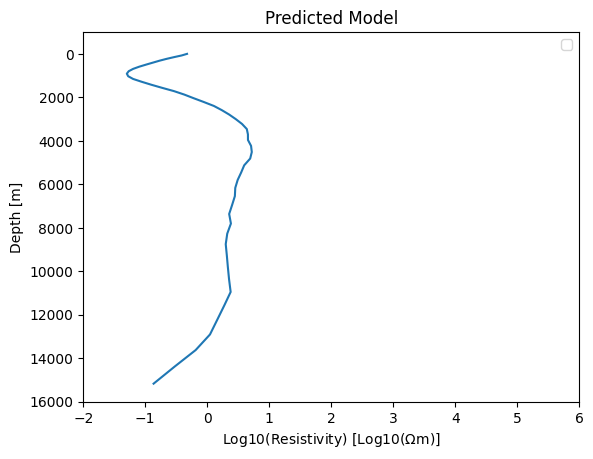

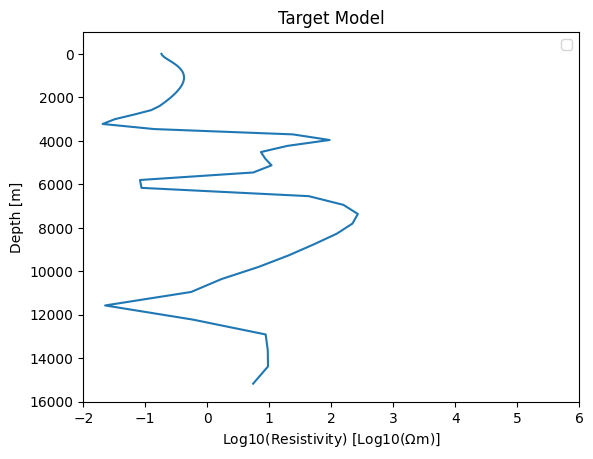

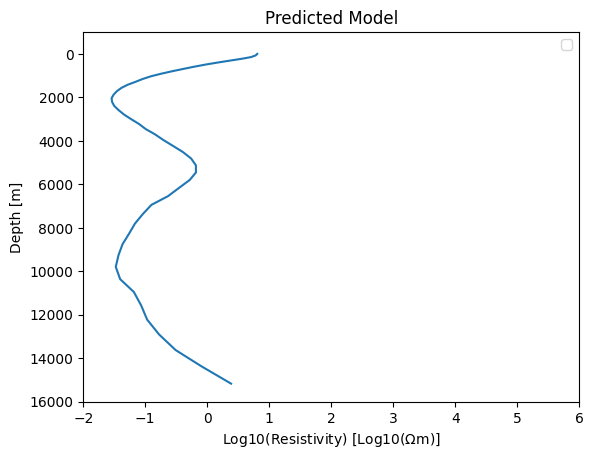

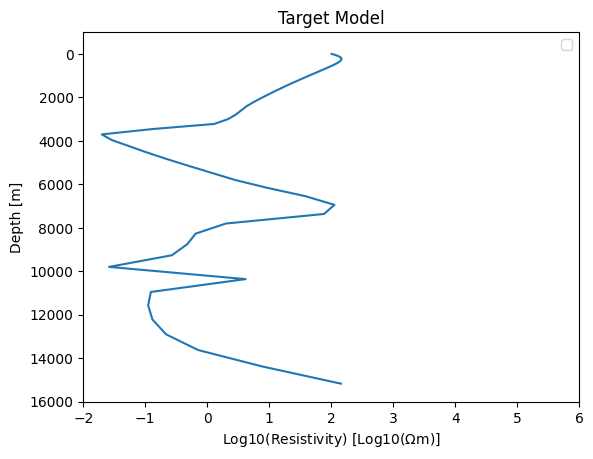

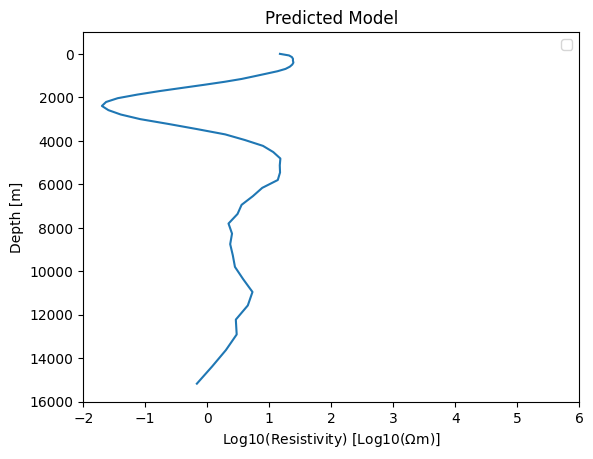

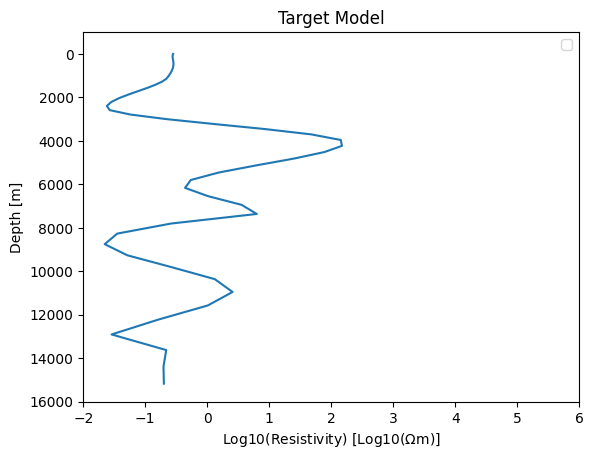

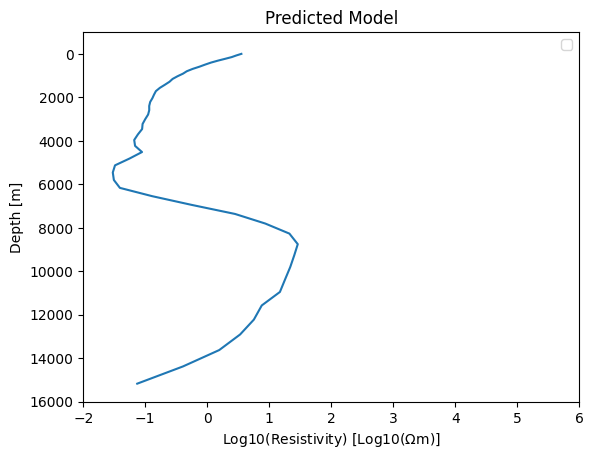

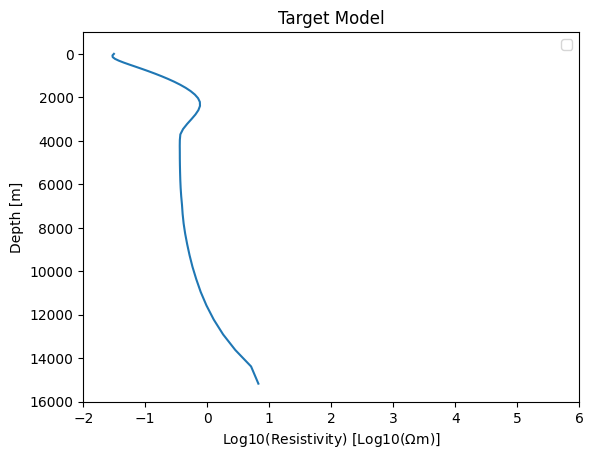

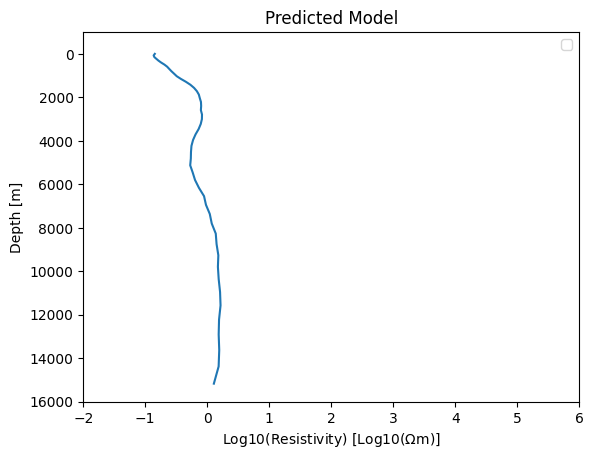

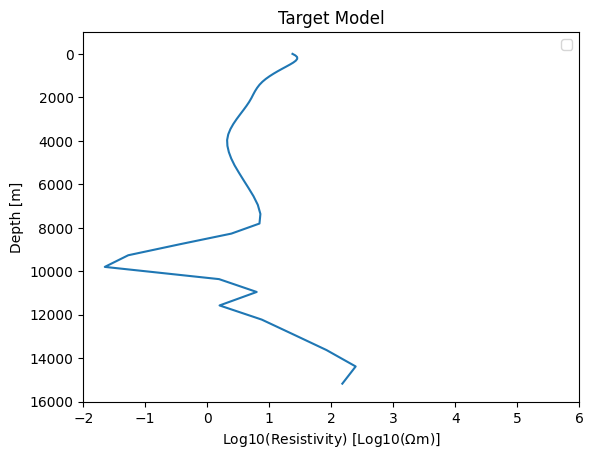

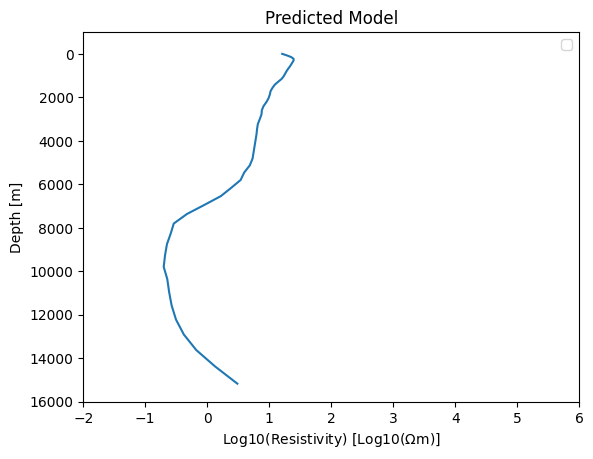

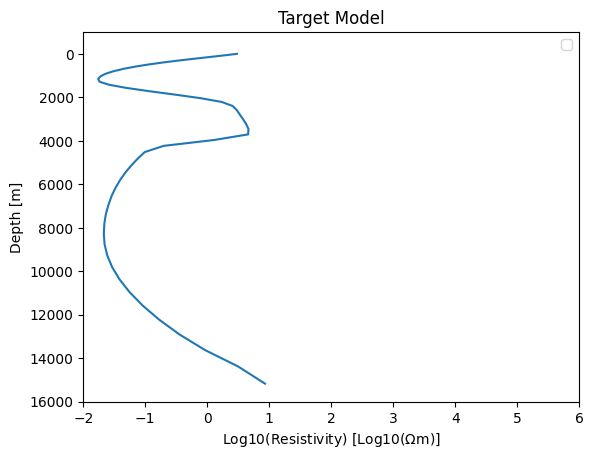

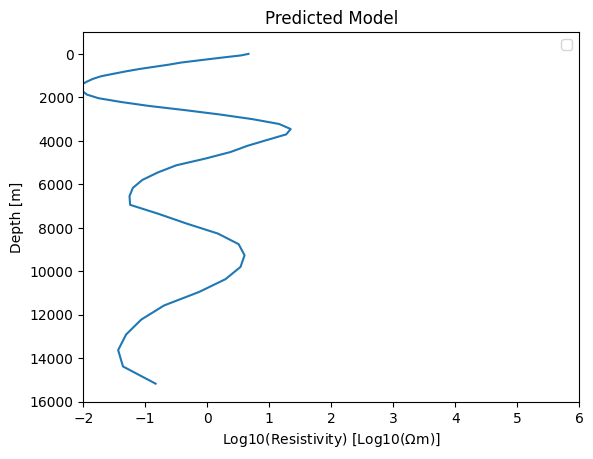

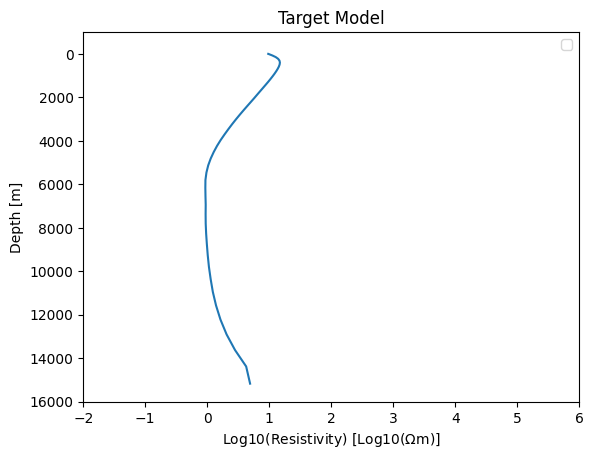

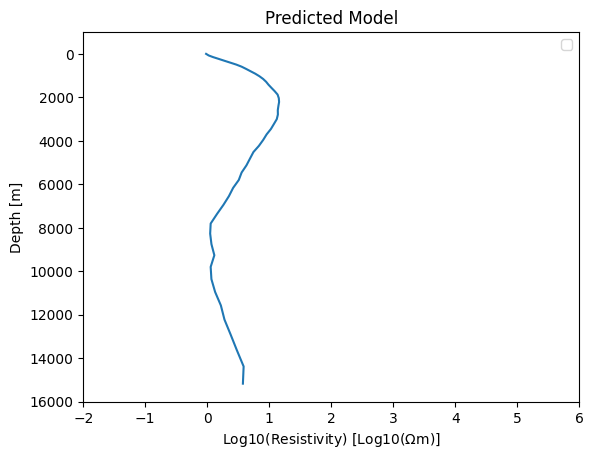

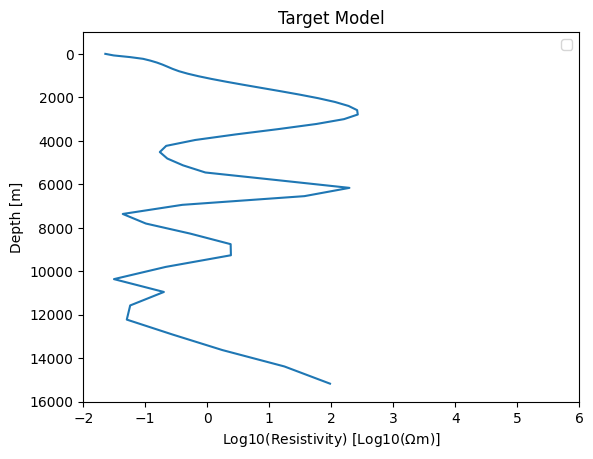

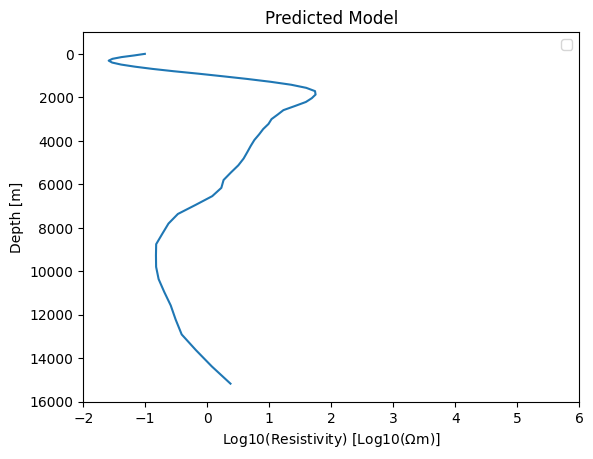

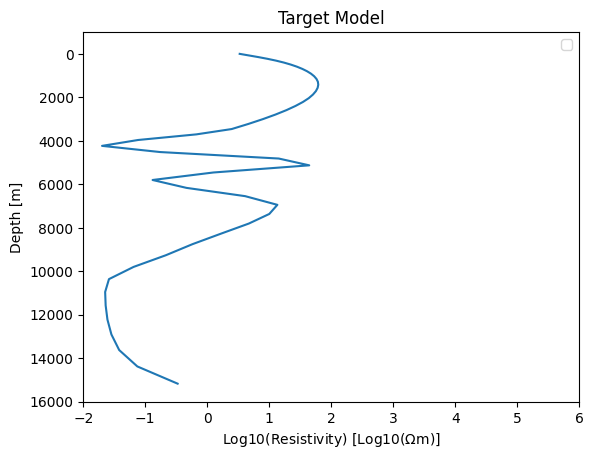

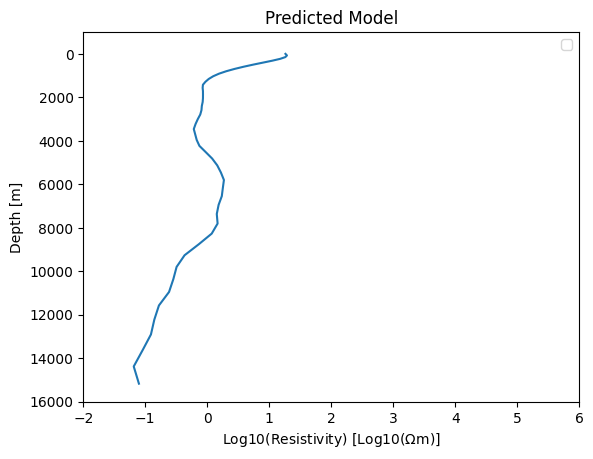

In [18]:
#Evaluate and plot predicted resistivity models

model.eval()
with torch.no_grad():
    inputs, targets = next(iter(test_loader))
    outputs = model(inputs)
num_samples = 10  # Number of data points to compare
for i in range(num_samples):
    #Plot predicted log10(resistivity) model

    plt.figure()
    #plt.plot(samples,inter_depths, 'o', label='Data points')
    #plt.plot(values,knots, '-')
    plt.title('Target Model')
    plt.plot(targets[i].numpy(),knots, '-')
    plt.legend()
    plt.xlabel('Log10(Resistivity) [Log10($\Omega$m)]')
    #plt.xscale("log")
    plt.ylabel('Depth [m]')
    plt.ylim(16000,-1000)
    plt.xlim(-2, 6)
    plt.show()

    #Plot predicted resistivity model

    #predictions_to_the_power_of_10 = np.power(10,mono_vals)
    plt.figure()
    #plt.plot(samples_to_the_power_of_10,inter_depths, 'o', label='Data points')
    #plt.plot(values,knots, '-')
    plt.title('Predicted Model')
    plt.plot(outputs[i].numpy(),knots, '-')
    plt.legend()
    plt.xlabel('Log10(Resistivity) [Log10($\Omega$m)]')
    #plt.xscale("log")
    plt.ylabel('Depth [m]')
    plt.ylim(16000,-1000)
    plt.xlim(-2, 6)
    plt.show()